In [2]:
import os
import cv2
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [3]:
# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((128, 128)),
            transforms.GaussianBlur(kernel_size=3),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30), 
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)), 
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_file_path = self.image_paths[idx]
        image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        image = self.transform(image)

        match = re.search(r'(\d+)-(\d+)', image_file_path)
        if not match:
            raise ValueError(f'Invalid image file path: {image_file_path}')
        num1, num2 = map(int, match.groups())

        label = num1

        return image, torch.tensor(label, dtype=torch.long)
        

In [4]:
# Load dataset from multiple directories
dataset_paths = ["dataset/images4/"]
image_paths = []
for path in dataset_paths:
    for subdir in os.listdir(path):
        for img in os.listdir(os.path.join(path, subdir)):
            image_paths.append(os.path.join(path, subdir, img))
            

# Split into training and testing sets
train_images, test_images = train_test_split(image_paths, test_size=0.2)

# Create train and test datasets
train_dataset = CustomDataset(train_images, "")
test_dataset = CustomDataset(test_images, "")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



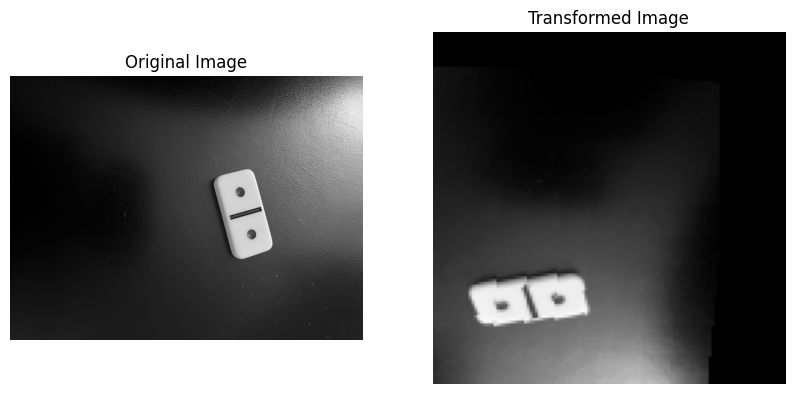

In [29]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

        
# Get a random image from the training dataset
random_idx = random.randint(0, len(train_dataset) - 1)
image_path = train_dataset.image_paths[random_idx]

# Load the original image
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = original_image.copy()
image = Image.fromarray(image)

# Apply transformations
transform_pipeline = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((128, 128)),
            transforms.GaussianBlur(kernel_size=3),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(30), 
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)), 
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

transformed_image = transform_pipeline(image)

# Convert tensors back to images for visualization
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove channel dimension
    tensor = tensor * 0.5 + 0.5  # Undo normalization
    return tensor.numpy()

# Plot original and transformed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show original image
axes[0].imshow(original_image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show transformed image
axes[1].imshow(tensor_to_image(transformed_image.T), cmap="gray")
axes[1].set_title("Transformed Image")
axes[1].axis("off")

# Display the images
plt.show()


In [30]:
class PipCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(PipCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)

        # **New Fourth Convolutional Block**
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)

        # **Global Average Pooling Instead of Flattening**
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers (Reduced neuron count to prevent overfitting)
        self.fc1 = nn.Linear(256, 128)  # Reduced size
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First Block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn1_2(self.conv1_2(x))))

        # Second Block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn2_2(self.conv2_2(x))))

        # Third Block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn3_2(self.conv3_2(x))))

        # Fourth Block (Newly Added)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Global Average Pooling (GAP)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten along the channel dimension

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


In [31]:
# Initialize model, loss function, and optimizer
epochs = 250


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = PipCNN().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)


for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
    
    train_accuracy = correct_predictions / total_samples * 100
    scheduler.step()

    # Run evaluation on the test set
    model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            test_correct += (predictions == labels).sum().item()
            test_total += labels.size(0)

    test_accuracy = test_correct / test_total * 100

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")

Epoch 1/250, Loss: 1.1591, Train Accuracy: 31.67%, Test Accuracy: 31.67%
Epoch 2/250, Loss: 1.1657, Train Accuracy: 36.67%, Test Accuracy: 31.67%
Epoch 3/250, Loss: 1.1014, Train Accuracy: 41.25%, Test Accuracy: 31.67%
Epoch 4/250, Loss: 1.0848, Train Accuracy: 39.58%, Test Accuracy: 30.00%
Epoch 5/250, Loss: 1.1110, Train Accuracy: 41.25%, Test Accuracy: 30.00%
Epoch 6/250, Loss: 1.0560, Train Accuracy: 42.50%, Test Accuracy: 45.00%
Epoch 7/250, Loss: 1.0240, Train Accuracy: 47.92%, Test Accuracy: 33.33%
Epoch 8/250, Loss: 1.0232, Train Accuracy: 47.50%, Test Accuracy: 43.33%
Epoch 9/250, Loss: 1.0074, Train Accuracy: 50.83%, Test Accuracy: 31.67%
Epoch 10/250, Loss: 0.9423, Train Accuracy: 53.33%, Test Accuracy: 41.67%
Epoch 11/250, Loss: 0.9717, Train Accuracy: 49.58%, Test Accuracy: 43.33%
Epoch 12/250, Loss: 0.9385, Train Accuracy: 55.42%, Test Accuracy: 40.00%
Epoch 13/250, Loss: 0.8991, Train Accuracy: 61.67%, Test Accuracy: 43.33%
Epoch 14/250, Loss: 0.9334, Train Accuracy: 54.

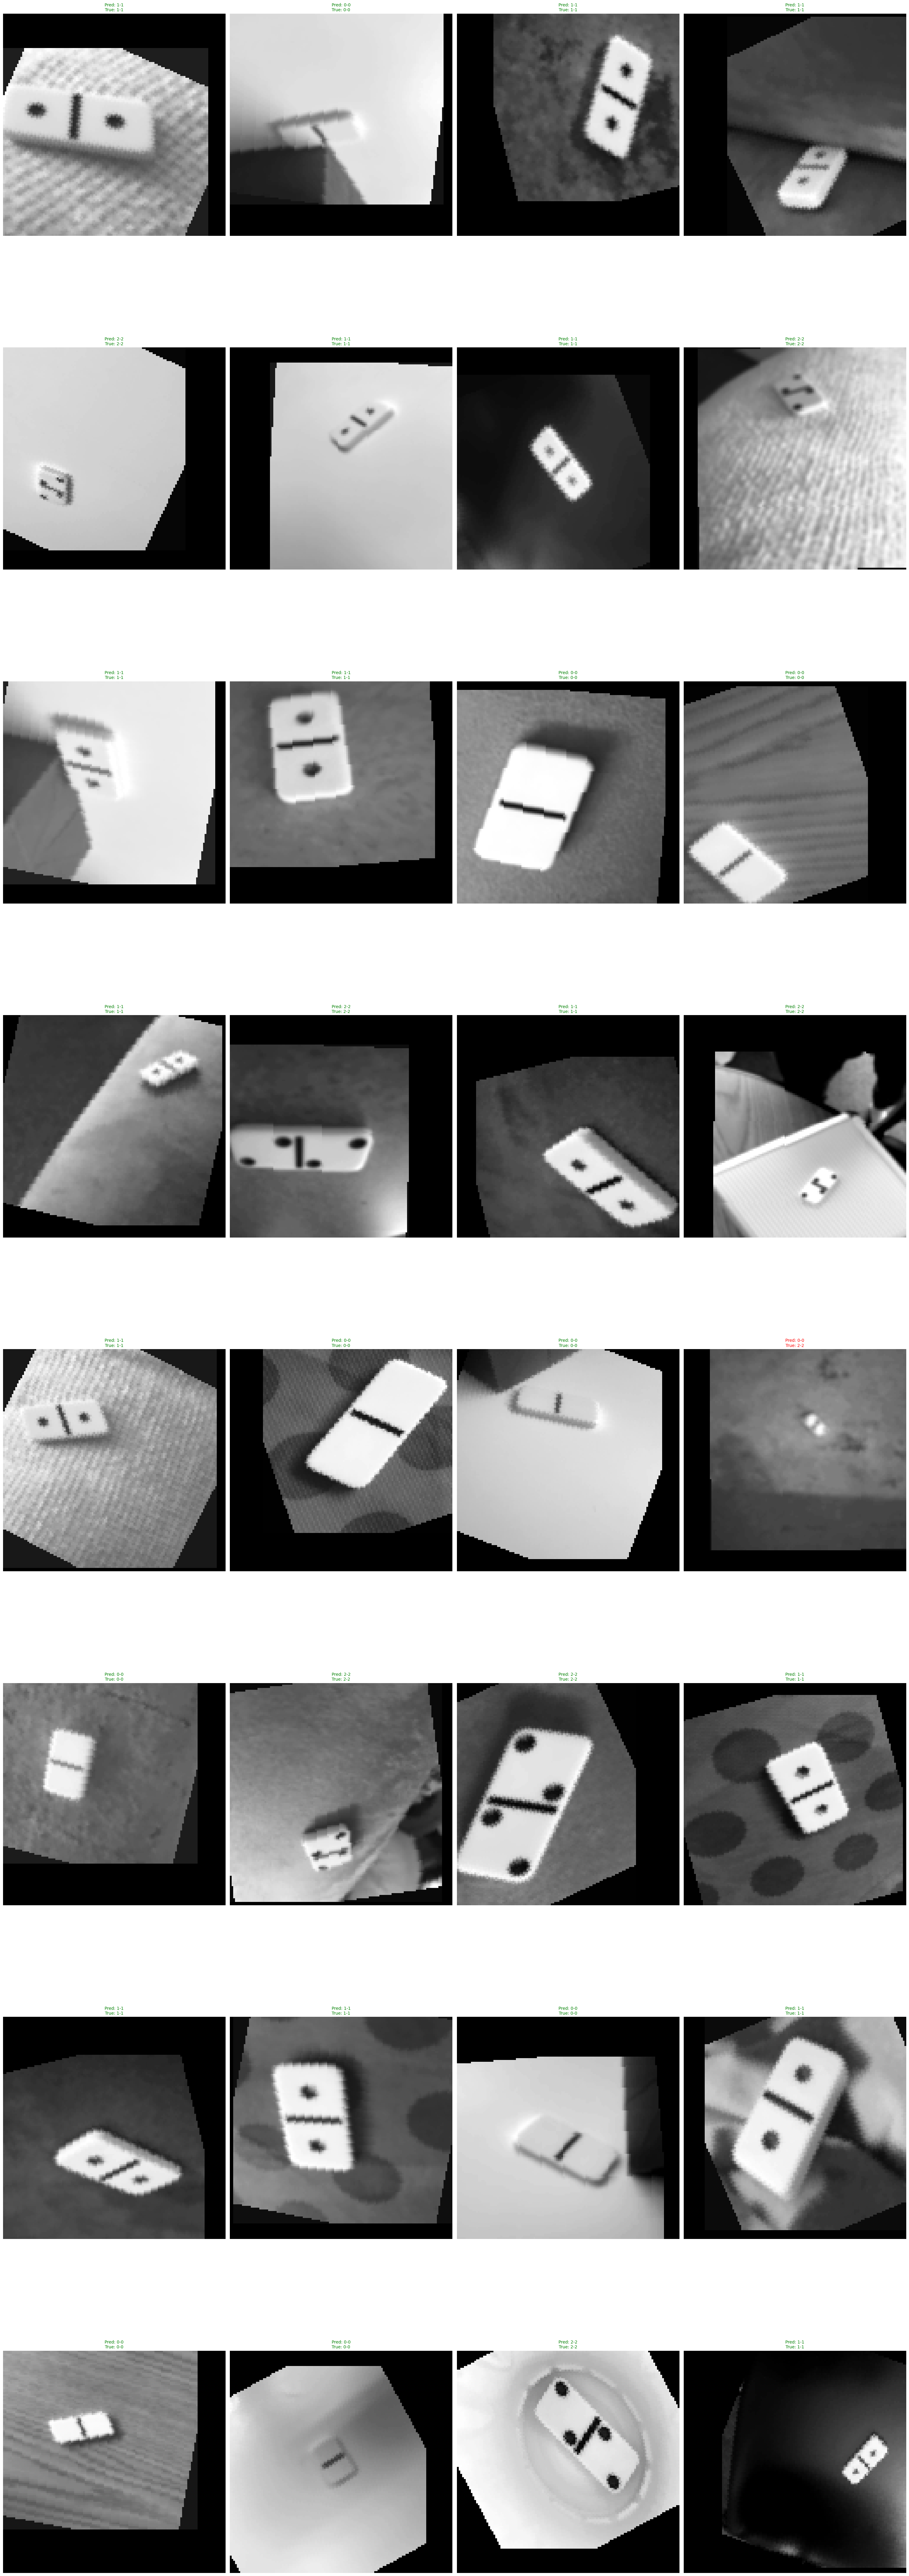

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
import torch

# Function to visualize test predictions
def visualize_predictions(model, test_loader, class_names, num_images=32):
    model.eval()  # Set model to evaluation mode
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    images, labels = next(iter(test_loader))  # Get a batch of test images
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)  # Get predictions
        _, preds = torch.max(outputs, 1)  # Convert logits to class indices
    
    images = images.cpu().numpy()
    
    # Denormalize images for visualization
    mean, std = 0.5, 0.5
    images = images * std + mean  # Undo normalization

    fig, axes = plt.subplots(8, 4, figsize=(30, 90))  # Create a 4x4 grid
    axes = axes.flatten()

    for idx in range(num_images):
        img = images[idx].squeeze(0)  # Remove extra channel dimension
        axes[idx].imshow(img, cmap="gray")
        axes[idx].axis("off")
        
        # Get true and predicted labels
        true_label = class_names[labels[idx].item()]
        predicted_label = class_names[preds[idx].item()]
        
        # Set title with color coding
        color = "green" if true_label == predicted_label else "red"
        axes[idx].set_title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color, fontsize=10)

    plt.tight_layout()
    plt.show()

# Define class names (adjust based on your dataset)
class_names = ["0-0", "1-1", "2-2"]  # Update this to match your dataset labels

# Call the function to visualize test predictions
visualize_predictions(model, test_loader, class_names, num_images=32)
